In [1]:
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
import data
from sklearn.preprocessing import StandardScaler
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from IPython.core.debugger import set_trace
import importlib
import numpy as np
import pandas as pd
import torch

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(42)

In [3]:
importlib.reload(data)

response_data = data.ExVivoDrugData.load_data()
merge_data = data.MergeData.load_data()

2019-11-19 14:28:44 INFO     Loading drug response data
2019-11-19 14:28:47 INFO     Drug response data loaded
2019-11-19 14:28:47 INFO     Loading merge data
2019-11-19 14:28:48 INFO     Merge data loaded


In [4]:
overlapping_genes = list(set(response_data.X.columns).intersection(merge_data.data.columns))
merge_data.data = merge_data.data[overlapping_genes]
response_data.X = response_data.X[["patient_id"] + response_data.drug_columns + overlapping_genes]

In [5]:
kfold_split = response_data.kfold_patient_split(5)

2019-11-19 14:28:50 INFO     Splitting drug response data into 5 folds
2019-11-19 14:28:56 INFO     Splitting complete


In [6]:
max_patients = 0
drug_with_max_patients = None

for drug_col in response_data.drug_columns:
    genotypes_for_drug = response_data.X[response_data.X[drug_col] == 1]
    genotypes_for_drug = genotypes_for_drug.groupby("patient_id").mean()
    patients_for_drug = genotypes_for_drug.shape[0]
    if patients_for_drug > max_patients:
        max_patients = patients_for_drug
        drug_with_max_patients = drug_col

In [7]:
import datetime
import time

criterion = MSELoss()
num_epochs = 300
learning_rate = 5e-7
prior_learning_rate = 5e-7

mlp_errors = []
def train(model, num_epochs):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    test_losses = []
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = model(X_batch)
            loss_train = criterion(output, y_batch)
            
            loss_train.backward()
            f1_optimizer.step()
            
        model.eval()
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = model(X_batch)
            loss_test = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
            test_losses.append(loss_test)
        
        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with test loss {:.4f}".format(epoch, epoch_time, loss_test))
    mlp_errors.append(test_losses)

In [8]:
from models import MLP
import torch
from torch import optim

data_loaders = []

for split in kfold_split:

    max_drug_indices_train = split.X_train[drug_with_max_patients] == 1
    max_drug_indices_test = split.X_test[drug_with_max_patients] == 1

    split.X_train = split.X_train[max_drug_indices_train].groupby("patient_id").mean()
    split.X_test = split.X_test[max_drug_indices_test].groupby("patient_id").mean()
    split.y_train = split.y_train[max_drug_indices_train].groupby("patient_id").mean()
    split.y_test = split.y_test[max_drug_indices_test].groupby("patient_id").mean()

    split.X_train.drop(response_data.drug_columns, axis=1, inplace=True)
    split.X_test.drop(response_data.drug_columns, axis=1, inplace=True)
    
    X_train = split.X_train
    y_train = split.y_train

    X_test = split.X_test
    y_test = split.y_test
    
    feature_scaler = StandardScaler()
    outcome_scaler = StandardScaler()

    logging.info("Fitting feature scalers")
    feature_scaler.fit(X_train[X_train.columns])
    outcome_scaler.fit(y_train[y_train.columns])
    logging.info("Finished fitting feature scalers")

    logging.info("Applying feature scalar")
    X_train[X_train.columns] = feature_scaler.transform(X_train[X_train.columns])
    X_test[X_test.columns] = feature_scaler.transform(X_test[X_test.columns])

    y_train[y_train.columns] = outcome_scaler.transform(y_train[y_train.columns])
    y_test[y_test.columns] = outcome_scaler.transform(y_test[y_test.columns])
    logging.info("Finished scaling features")
    
    # Create random Tensors to hold inputs and outputs
    train_dataset = data.ExVivoDrugData(X_train, y_train)
    test_dataset = data.ExVivoDrugData(X_test, y_test)

    batch_size=32
    
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=X_test.shape[0],
        shuffle=False,
        drop_last=False
    )
    data_loaders.append((train_loader, test_loader))
    


2019-11-19 14:29:09 INFO     Fitting feature scalers
2019-11-19 14:29:09 INFO     Finished fitting feature scalers
2019-11-19 14:29:09 INFO     Applying feature scalar
2019-11-19 14:29:09 INFO     Finished scaling features
2019-11-19 14:29:10 INFO     Fitting feature scalers
2019-11-19 14:29:10 INFO     Finished fitting feature scalers
2019-11-19 14:29:10 INFO     Applying feature scalar
2019-11-19 14:29:10 INFO     Finished scaling features
2019-11-19 14:29:10 INFO     Fitting feature scalers
2019-11-19 14:29:10 INFO     Finished fitting feature scalers
2019-11-19 14:29:10 INFO     Applying feature scalar
2019-11-19 14:29:10 INFO     Finished scaling features
2019-11-19 14:29:10 INFO     Fitting feature scalers
2019-11-19 14:29:10 INFO     Finished fitting feature scalers
2019-11-19 14:29:10 INFO     Applying feature scalar
2019-11-19 14:29:11 INFO     Finished scaling features
2019-11-19 14:29:11 INFO     Fitting feature scalers
2019-11-19 14:29:11 INFO     Finished fitting feature s

In [9]:
for train_loader, test_loader in data_loaders:
    D_in, H1, H2, D_out = train_loader.dataset.X.shape[1], 512, 256, 1
    f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
    f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate, weight_decay=5e-3)
    
    train(f1, num_epochs)

2019-11-19 14:29:16 INFO     Epoch 0 completed in 0.1765742301940918 secs with test loss 1.2593


Beginning model training at 2019-11-19 14:29:15.847297


2019-11-19 14:29:17 INFO     Epoch 10 completed in 0.15610790252685547 secs with test loss 1.2000
2019-11-19 14:29:19 INFO     Epoch 20 completed in 0.1710190773010254 secs with test loss 1.1533
2019-11-19 14:29:20 INFO     Epoch 30 completed in 0.16427016258239746 secs with test loss 1.1143
2019-11-19 14:29:22 INFO     Epoch 40 completed in 0.13194680213928223 secs with test loss 1.0793
2019-11-19 14:29:23 INFO     Epoch 50 completed in 0.14963436126708984 secs with test loss 1.0492
2019-11-19 14:29:25 INFO     Epoch 60 completed in 0.14305639266967773 secs with test loss 1.0251
2019-11-19 14:29:26 INFO     Epoch 70 completed in 0.16179180145263672 secs with test loss 1.0018
2019-11-19 14:29:27 INFO     Epoch 80 completed in 0.13712310791015625 secs with test loss 0.9796
2019-11-19 14:29:29 INFO     Epoch 90 completed in 0.16399025917053223 secs with test loss 0.9589
2019-11-19 14:29:30 INFO     Epoch 100 completed in 0.1501002311706543 secs with test loss 0.9405
2019-11-19 14:29:32 I

Beginning model training at 2019-11-19 14:30:00.292810


2019-11-19 14:30:02 INFO     Epoch 10 completed in 0.15687227249145508 secs with test loss 0.9446
2019-11-19 14:30:03 INFO     Epoch 20 completed in 0.1638026237487793 secs with test loss 0.9204
2019-11-19 14:30:05 INFO     Epoch 30 completed in 0.15963244438171387 secs with test loss 0.9036
2019-11-19 14:30:06 INFO     Epoch 40 completed in 0.15449786186218262 secs with test loss 0.8925
2019-11-19 14:30:08 INFO     Epoch 50 completed in 0.15540146827697754 secs with test loss 0.8850
2019-11-19 14:30:09 INFO     Epoch 60 completed in 0.16705608367919922 secs with test loss 0.8818
2019-11-19 14:30:11 INFO     Epoch 70 completed in 0.14810991287231445 secs with test loss 0.8779
2019-11-19 14:30:13 INFO     Epoch 80 completed in 0.16436314582824707 secs with test loss 0.8774
2019-11-19 14:30:14 INFO     Epoch 90 completed in 0.16453981399536133 secs with test loss 0.8769
2019-11-19 14:30:15 INFO     Epoch 100 completed in 0.1360328197479248 secs with test loss 0.8767
2019-11-19 14:30:17 I

Beginning model training at 2019-11-19 14:30:47.871568


2019-11-19 14:30:49 INFO     Epoch 10 completed in 0.18045973777770996 secs with test loss 1.0627
2019-11-19 14:30:51 INFO     Epoch 20 completed in 0.16238665580749512 secs with test loss 1.0372
2019-11-19 14:30:53 INFO     Epoch 30 completed in 0.188307523727417 secs with test loss 1.0193
2019-11-19 14:30:55 INFO     Epoch 40 completed in 0.18059825897216797 secs with test loss 1.0054
2019-11-19 14:30:57 INFO     Epoch 50 completed in 0.16755223274230957 secs with test loss 0.9949
2019-11-19 14:30:59 INFO     Epoch 60 completed in 0.17550969123840332 secs with test loss 0.9844
2019-11-19 14:31:00 INFO     Epoch 70 completed in 0.17722702026367188 secs with test loss 0.9733
2019-11-19 14:31:02 INFO     Epoch 80 completed in 0.17249083518981934 secs with test loss 0.9625
2019-11-19 14:31:04 INFO     Epoch 90 completed in 0.20474004745483398 secs with test loss 0.9544
2019-11-19 14:31:06 INFO     Epoch 100 completed in 0.17523407936096191 secs with test loss 0.9483
2019-11-19 14:31:08 I

Beginning model training at 2019-11-19 14:31:43.371845


2019-11-19 14:31:45 INFO     Epoch 10 completed in 0.19618463516235352 secs with test loss 0.9570
2019-11-19 14:31:47 INFO     Epoch 20 completed in 0.18424296379089355 secs with test loss 0.9523
2019-11-19 14:31:49 INFO     Epoch 30 completed in 0.16146469116210938 secs with test loss 0.9502
2019-11-19 14:31:50 INFO     Epoch 40 completed in 0.1896531581878662 secs with test loss 0.9488
2019-11-19 14:31:52 INFO     Epoch 50 completed in 0.16680121421813965 secs with test loss 0.9484
2019-11-19 14:31:54 INFO     Epoch 60 completed in 0.18910932540893555 secs with test loss 0.9458
2019-11-19 14:31:56 INFO     Epoch 70 completed in 0.16406631469726562 secs with test loss 0.9445
2019-11-19 14:31:58 INFO     Epoch 80 completed in 0.18182110786437988 secs with test loss 0.9431
2019-11-19 14:31:59 INFO     Epoch 90 completed in 0.17387628555297852 secs with test loss 0.9416
2019-11-19 14:32:01 INFO     Epoch 100 completed in 0.18089866638183594 secs with test loss 0.9420
2019-11-19 14:32:03 

Beginning model training at 2019-11-19 14:32:36.512921


2019-11-19 14:32:38 INFO     Epoch 10 completed in 0.16616201400756836 secs with test loss 0.8723
2019-11-19 14:32:39 INFO     Epoch 20 completed in 0.1341862678527832 secs with test loss 0.8398
2019-11-19 14:32:41 INFO     Epoch 30 completed in 0.13217735290527344 secs with test loss 0.8163
2019-11-19 14:32:42 INFO     Epoch 40 completed in 0.14281344413757324 secs with test loss 0.7951
2019-11-19 14:32:44 INFO     Epoch 50 completed in 0.2981128692626953 secs with test loss 0.7788
2019-11-19 14:32:47 INFO     Epoch 60 completed in 0.2852511405944824 secs with test loss 0.7634
2019-11-19 14:32:49 INFO     Epoch 70 completed in 0.264315128326416 secs with test loss 0.7512
2019-11-19 14:32:52 INFO     Epoch 80 completed in 0.21540522575378418 secs with test loss 0.7399
2019-11-19 14:32:54 INFO     Epoch 90 completed in 0.21292400360107422 secs with test loss 0.7288
2019-11-19 14:32:56 INFO     Epoch 100 completed in 0.2275681495666504 secs with test loss 0.7206
2019-11-19 14:32:59 INFO 

In [10]:
import egexplainer
import importlib

importlib.reload(egexplainer)

APExp = egexplainer.VariableBatchExplainer(train_dataset)

In [11]:
from models import LinearModel

prior_info = merge_data.data.T
prior_info = torch.FloatTensor(prior_info.values).cuda()
prior_mlp_errors = []

def train_with_learned_prior(f1, f2, num_epochs):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    test_losses = []
    for epoch in range(num_epochs):
        start_time = time.time()
        f1.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            f2_optimizer.zero_grad()
            
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = f1(X_batch)
            
            eg = APExp.shap_values(f1, X_batch)
            prior_differences = f2(prior_info).squeeze()
            prior_loss = (prior_differences - eg).abs().mean()
            
            loss_train = criterion(output, y_batch) + prior_loss
            
            loss_train.backward()
            f1_optimizer.step()
            f2_optimizer.step()
            
        f1.eval()
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = f1(X_batch)
            loss_test = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
            test_losses.append(loss_test)
        
        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with test loss {:.4f}".format(epoch, epoch_time, loss_test))
    prior_mlp_errors.append(test_losses)

In [12]:
for train_loader, test_loader in data_loaders:
    D_in, H1, H2, D_out = X_train.shape[1], 512, 256, 1
    f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
    f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate)
    
    """
    f2 = LinearModel(
        D_in = prior_info.shape[1],
        D_out = 1
    ).cuda()
    """
    f2 = MLP(
        D_in = prior_info.shape[1],
        H1 = 5,
        H2 = 3,
        D_out = 1,
        dropout = 0.0
    ).cuda().float()
    f2_optimizer = optim.Adam(f2.parameters(), lr=prior_learning_rate)

    train_with_learned_prior(f1, f2, num_epochs)

Beginning model training at 2019-11-19 14:33:45.287454


2019-11-19 14:33:45 INFO     Epoch 0 completed in 0.5583808422088623 secs with test loss 1.1907
2019-11-19 14:33:51 INFO     Epoch 10 completed in 0.4589662551879883 secs with test loss 1.1328
2019-11-19 14:33:56 INFO     Epoch 20 completed in 0.5226585865020752 secs with test loss 1.0880
2019-11-19 14:34:02 INFO     Epoch 30 completed in 0.5782899856567383 secs with test loss 1.0490
2019-11-19 14:34:07 INFO     Epoch 40 completed in 0.5155935287475586 secs with test loss 1.0170
2019-11-19 14:34:13 INFO     Epoch 50 completed in 0.4680027961730957 secs with test loss 0.9899
2019-11-19 14:34:17 INFO     Epoch 60 completed in 0.4115591049194336 secs with test loss 0.9638
2019-11-19 14:34:21 INFO     Epoch 70 completed in 0.3365013599395752 secs with test loss 0.9409
2019-11-19 14:34:24 INFO     Epoch 80 completed in 0.32122015953063965 secs with test loss 0.9193
2019-11-19 14:34:28 INFO     Epoch 90 completed in 0.3170621395111084 secs with test loss 0.9005
2019-11-19 14:34:31 INFO     E

Beginning model training at 2019-11-19 14:35:38.938061


2019-11-19 14:35:39 INFO     Epoch 0 completed in 0.37461185455322266 secs with test loss 0.9514
2019-11-19 14:35:42 INFO     Epoch 10 completed in 0.37224411964416504 secs with test loss 0.9144
2019-11-19 14:35:46 INFO     Epoch 20 completed in 0.34304165840148926 secs with test loss 0.8878
2019-11-19 14:35:49 INFO     Epoch 30 completed in 0.3640284538269043 secs with test loss 0.8698
2019-11-19 14:35:52 INFO     Epoch 40 completed in 0.33327221870422363 secs with test loss 0.8565
2019-11-19 14:35:56 INFO     Epoch 50 completed in 0.346327543258667 secs with test loss 0.8464
2019-11-19 14:35:59 INFO     Epoch 60 completed in 0.3618898391723633 secs with test loss 0.8372
2019-11-19 14:36:03 INFO     Epoch 70 completed in 0.33890795707702637 secs with test loss 0.8338
2019-11-19 14:36:06 INFO     Epoch 80 completed in 0.31929826736450195 secs with test loss 0.8302
2019-11-19 14:36:09 INFO     Epoch 90 completed in 0.3290882110595703 secs with test loss 0.8266
2019-11-19 14:36:13 INFO  

Beginning model training at 2019-11-19 14:37:21.104058


2019-11-19 14:37:21 INFO     Epoch 0 completed in 0.3278470039367676 secs with test loss 1.0931
2019-11-19 14:37:24 INFO     Epoch 10 completed in 0.35750842094421387 secs with test loss 1.0640
2019-11-19 14:37:28 INFO     Epoch 20 completed in 0.3404245376586914 secs with test loss 1.0461
2019-11-19 14:37:31 INFO     Epoch 30 completed in 0.3400611877441406 secs with test loss 1.0339
2019-11-19 14:37:34 INFO     Epoch 40 completed in 0.33779430389404297 secs with test loss 1.0215
2019-11-19 14:37:38 INFO     Epoch 50 completed in 0.351093053817749 secs with test loss 1.0112
2019-11-19 14:37:41 INFO     Epoch 60 completed in 0.35233068466186523 secs with test loss 1.0006
2019-11-19 14:37:45 INFO     Epoch 70 completed in 0.3313000202178955 secs with test loss 0.9907
2019-11-19 14:37:48 INFO     Epoch 80 completed in 0.441425085067749 secs with test loss 0.9817
2019-11-19 14:37:52 INFO     Epoch 90 completed in 0.32799768447875977 secs with test loss 0.9720
2019-11-19 14:37:56 INFO     

Beginning model training at 2019-11-19 14:39:04.814127


2019-11-19 14:39:05 INFO     Epoch 0 completed in 0.3176236152648926 secs with test loss 0.9756
2019-11-19 14:39:08 INFO     Epoch 10 completed in 0.3239450454711914 secs with test loss 0.9598
2019-11-19 14:39:11 INFO     Epoch 20 completed in 0.35327744483947754 secs with test loss 0.9506
2019-11-19 14:39:15 INFO     Epoch 30 completed in 0.3551640510559082 secs with test loss 0.9439
2019-11-19 14:39:19 INFO     Epoch 40 completed in 0.40828776359558105 secs with test loss 0.9398
2019-11-19 14:39:23 INFO     Epoch 50 completed in 0.31713247299194336 secs with test loss 0.9357
2019-11-19 14:39:26 INFO     Epoch 60 completed in 0.3210899829864502 secs with test loss 0.9321
2019-11-19 14:39:29 INFO     Epoch 70 completed in 0.4410715103149414 secs with test loss 0.9296
2019-11-19 14:39:33 INFO     Epoch 80 completed in 0.3487734794616699 secs with test loss 0.9257
2019-11-19 14:39:36 INFO     Epoch 90 completed in 0.3422861099243164 secs with test loss 0.9210
2019-11-19 14:39:40 INFO    

Beginning model training at 2019-11-19 14:40:49.254799


2019-11-19 14:40:49 INFO     Epoch 0 completed in 0.36090946197509766 secs with test loss 0.9227
2019-11-19 14:40:52 INFO     Epoch 10 completed in 0.35300111770629883 secs with test loss 0.8727
2019-11-19 14:40:56 INFO     Epoch 20 completed in 0.33130526542663574 secs with test loss 0.8327
2019-11-19 14:40:59 INFO     Epoch 30 completed in 0.3367786407470703 secs with test loss 0.8056
2019-11-19 14:41:03 INFO     Epoch 40 completed in 0.36346960067749023 secs with test loss 0.7832
2019-11-19 14:41:06 INFO     Epoch 50 completed in 0.37520670890808105 secs with test loss 0.7661
2019-11-19 14:41:10 INFO     Epoch 60 completed in 0.36143994331359863 secs with test loss 0.7520
2019-11-19 14:41:13 INFO     Epoch 70 completed in 0.3316195011138916 secs with test loss 0.7398
2019-11-19 14:41:16 INFO     Epoch 80 completed in 0.3183937072753906 secs with test loss 0.7288
2019-11-19 14:41:20 INFO     Epoch 90 completed in 0.3416914939880371 secs with test loss 0.7203
2019-11-19 14:41:23 INFO 

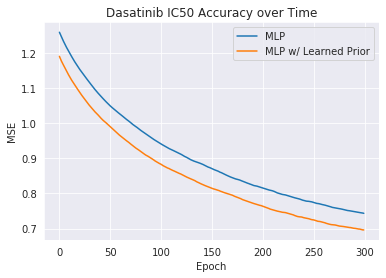

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.plot(mlp_errors[0], label="MLP")
plt.plot(prior_mlp_errors[0], label="MLP w/ Learned Prior")
plt.title("{} IC50 Accuracy over Time".format(drug_with_max_patients[5:]))
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [28]:
from data import BasicDataset

prior_data = BasicDataset(X = prior_info, y = np.zeros(prior_info.shape[0]))

meta_APExp = egexplainer.VariableBatchExplainer(prior_data)

In [39]:
test_loader = data_loaders[1][1]
for X_batch, y_batch in test_loader:
    y_batch = y_batch.squeeze()
    X_batch = X_batch.float().cuda()
    y_batch = y_batch.float().cuda()
    predicted_attributions = f2(prior_info).abs().squeeze().cpu().detach().numpy()
    meta_eg = meta_APExp.shap_values(f2, prior_info).abs().cpu().detach().numpy()

In [120]:
meta_eg = np.abs(meta_eg)
row_sums = meta_eg.sum(axis=1)
meta_eg = meta_eg / row_sums[:, np.newaxis]
meta_eg = (meta_eg.T * predicted_attributions).T
df = pd.DataFrame(data={
    "Mutation": meta_eg[:,0],
    "Hubness": meta_eg[:,1],
    "Regulator": meta_eg[:,2],
    "CNV": meta_eg[:,3],
    "Methylation": meta_eg[:,4],
    "total_attribution": predicted_attributions,
    "y":merge_data.data.columns
})

In [121]:
num_bars = 25
data_to_plot = df.dropna().nlargest(num_bars, "total_attribution")

In [122]:
data_to_plot = data_to_plot.sort_values(by="total_attribution", ascending=True)
data_to_plot.drop("total_attribution", axis=1, inplace=True)
data_to_plot.set_index("y", inplace=True)

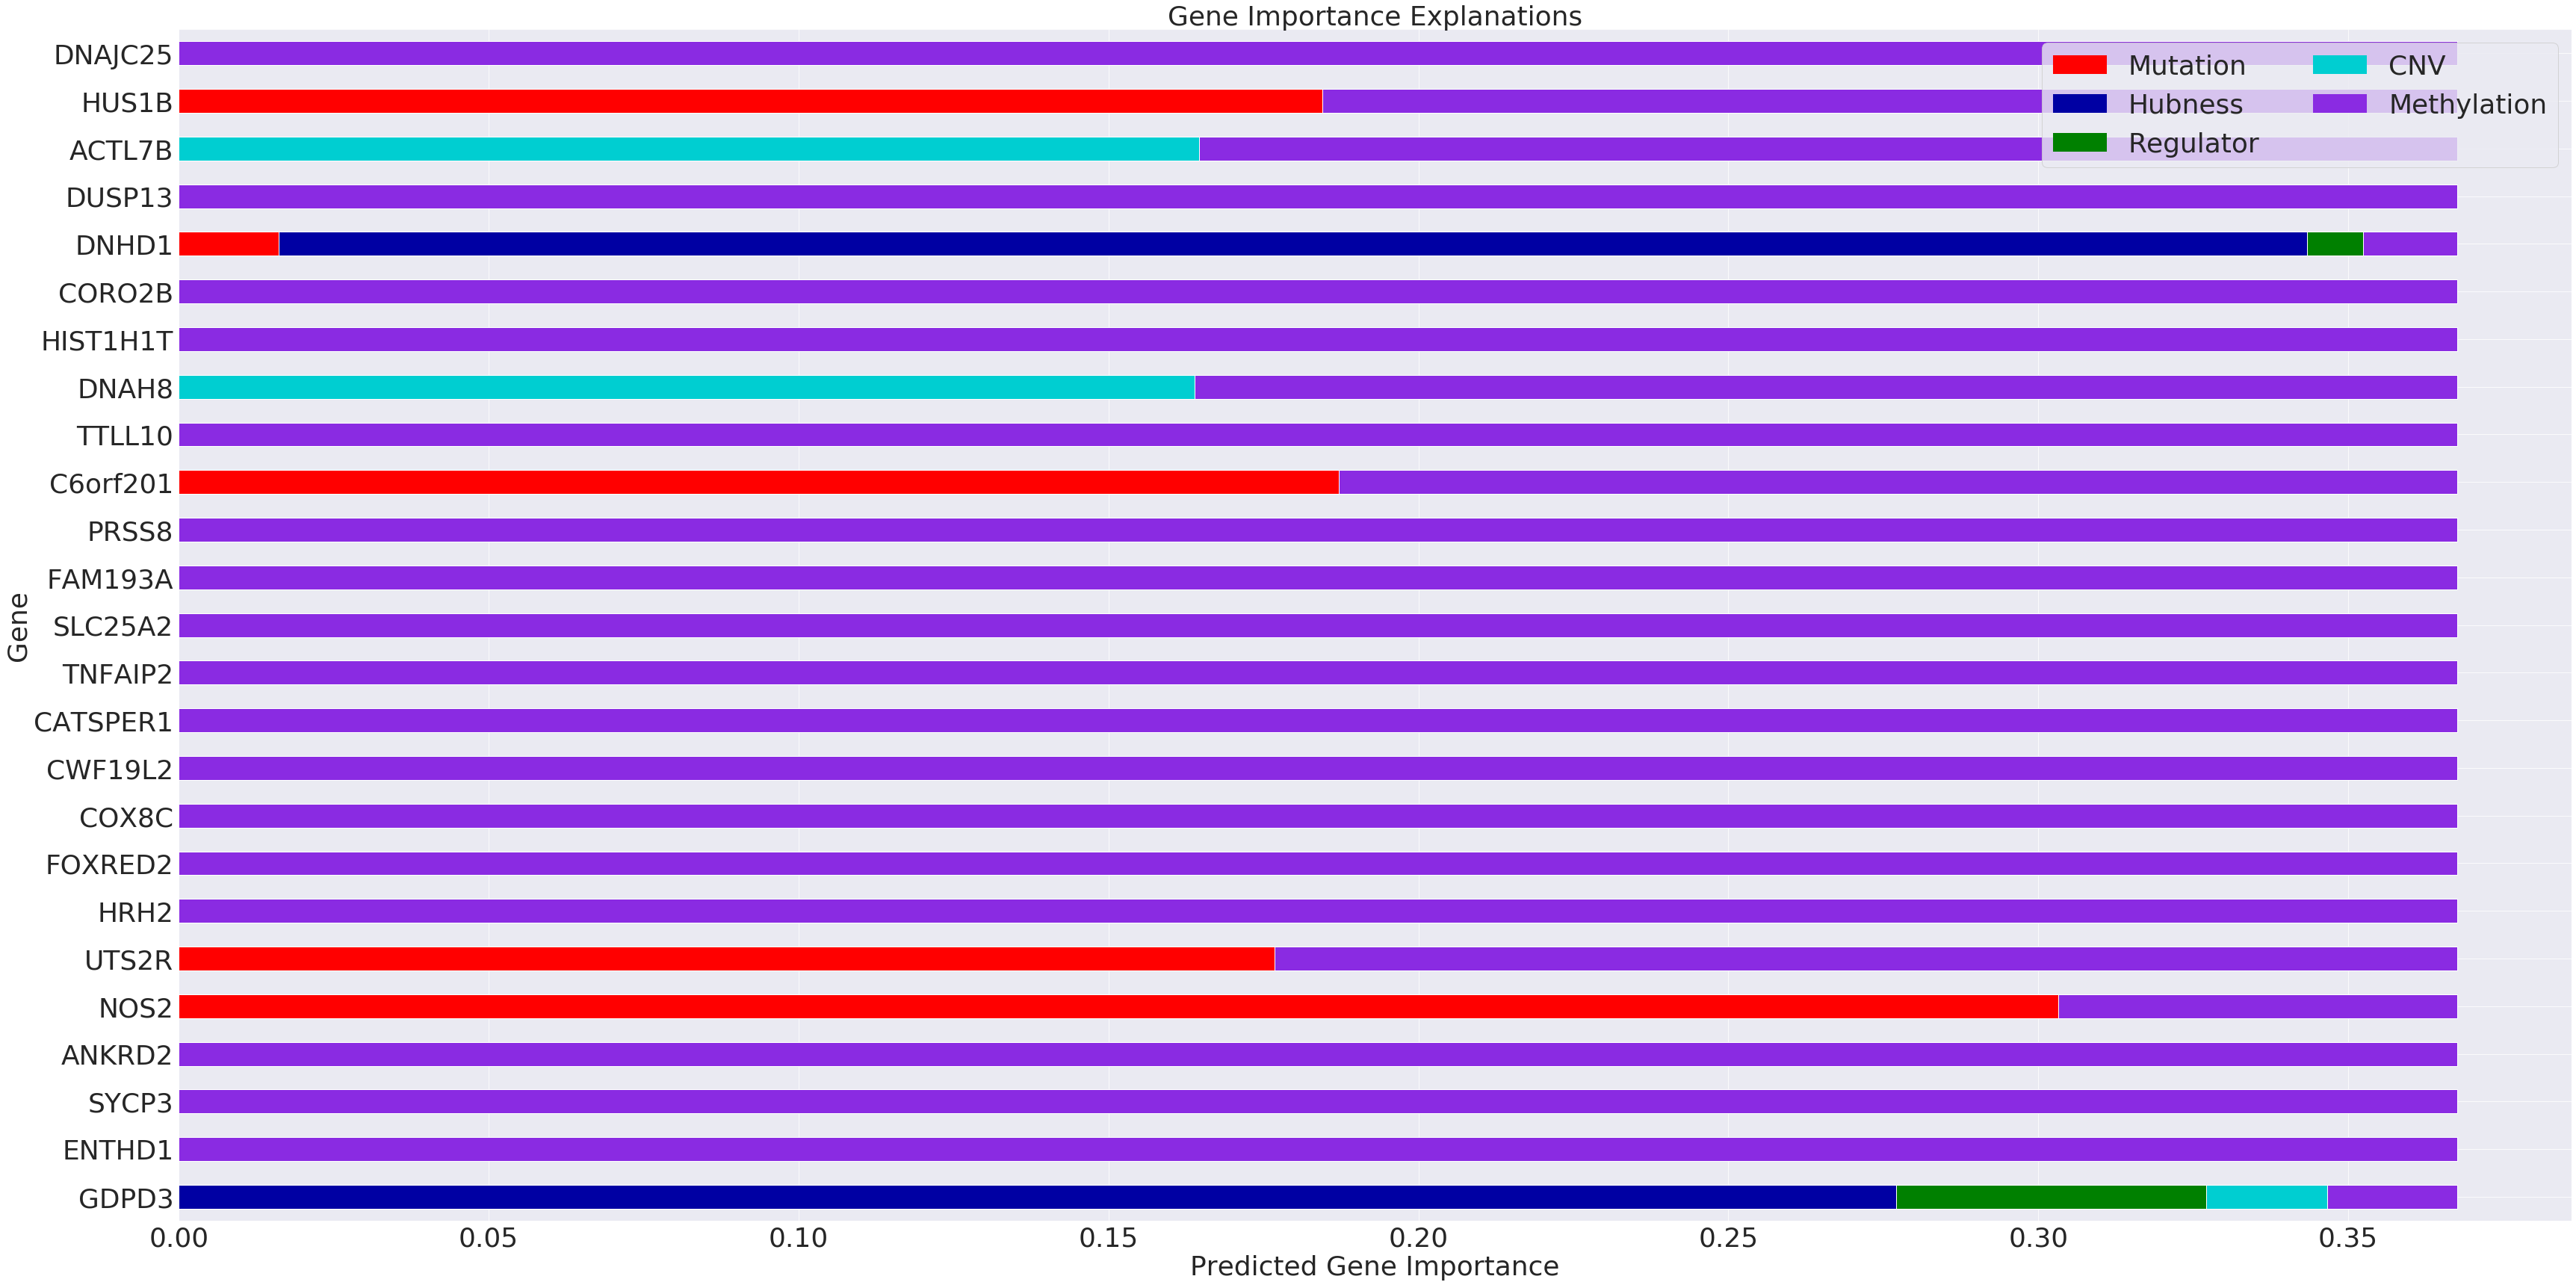

In [123]:
colors = {
    "mutation": "red",
    "hubness": "#0000A3",
    "regulator": "#008000",
    "cnv": "#00CED1",
    "methylation": "#8A2BE2"
}

mutation_bar = plt.Rectangle((0,0),1,1,fc=colors["mutation"], edgecolor = 'none')
hubness_bar = plt.Rectangle((0,0),1,1,fc=colors["hubness"],  edgecolor = 'none')
regulator_bar = plt.Rectangle((0,0),1,1,fc=colors["regulator"],  edgecolor = 'none')
cnv_bar = plt.Rectangle((0,0),1,1,fc=colors["cnv"], edgecolor = 'none')
methylation_bar = plt.Rectangle((0,0),1,1,fc=colors["methylation"],edgecolor = 'none')

data_to_plot.plot(
    kind="barh",
    stacked=True,
    color=[
        colors["mutation"],
        colors["hubness"],
        colors["regulator"],
        colors["cnv"],
        colors["methylation"]
    ],
    figsize=(48,24)
)

plt.xticks(fontsize=36)
plt.yticks(fontsize=36)

plt.legend(
    [mutation_bar, hubness_bar, regulator_bar, cnv_bar, methylation_bar],
    ['Mutation', 'Hubness', "Regulator", "CNV", "Methylation"],
    ncol = 2,
    prop={'size':36}
)

plt.title("Gene Importance Explanations", fontsize=36)
plt.ylabel("Gene", fontsize=36)
plt.xlabel("Predicted Gene Importance", fontsize=36)
plt.tight_layout()

In [65]:
from sklearn import linear_model

potential_alphas = np.linspace(start=0, stop=1, num=100)[1:]
lasso_errors = []
for train_loader, test_loader in data_loaders:
    best_mse = float("inf")
    for alpha in potential_alphas:
        clf = linear_model.Lasso(alpha=alpha)
        clf.fit(train_loader.dataset.X, train_loader.dataset.y)
        predictions = clf.predict(test_loader.dataset.X)
        mse = ((predictions - test_loader.dataset.y.values)**2).mean()
        if mse < best_mse:
            best_mse = mse
    lasso_errors.append(best_mse)

(0.6, 1.1245429328694134)

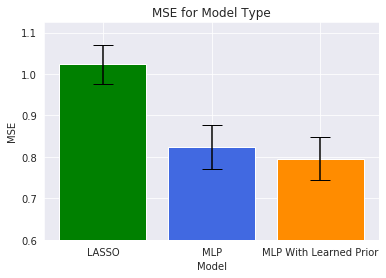

In [80]:
from scipy.stats import sem

lasso_errors = np.array(lasso_errors)
final_mlp_errors = np.array([errors[-1] for errors in mlp_errors])
final_prior_mlp_errors = np.array([errors[-1] for errors in prior_mlp_errors])

mean_errors = [
    lasso_errors.mean(),
    final_mlp_errors.mean(),
    final_prior_mlp_errors.mean()
]

stderr = [
    sem(lasso_errors),
    sem(final_mlp_errors),
    sem(final_prior_mlp_errors)
]

df = pd.DataFrame()

plt.bar(
    ["LASSO", "MLP", "MLP With Learned Prior"],
    mean_errors,
    yerr = stderr,
    align='center',
    ecolor='black',
    capsize=10,
    color=['green', 'royalblue', 'darkorange']
)
plt.title("MSE for Model Type")
plt.xlabel("Model")
plt.ylabel("MSE")
plt.ylim(0.6)

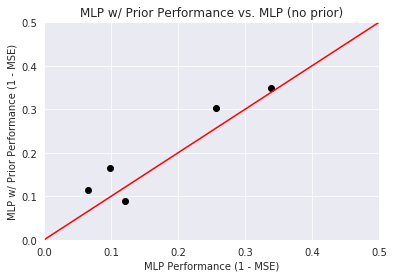

In [101]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
ax.scatter(x=1-final_mlp_errors, y=1-final_prior_mlp_errors, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.xlabel("MLP Performance (1 - MSE)")
plt.ylabel("MLP w/ Prior Performance (1 - MSE)")
plt.title("MLP w/ Prior Performance vs. MLP (no prior)")
plt.show()

In [92]:
1/final_mlp_errors

array([1.34511415, 1.10859279, 1.13722935, 1.07098803, 1.51265317])

In [93]:
1/final_prior_mlp_errors

array([1.43647509, 1.19862428, 1.09914174, 1.12990722, 1.53614326])